#   SQL- Kunskapskontroll

In [91]:
# Importera nödvändiga bibliotek
from sqlalchemy import create_engine, Table, inspect
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

In [92]:
# Funktion för att skapa en anslutning till databasen
def new_engine(dialect, server, database, user=None, password=None, integrated_security=True):
    if integrated_security:
        # For Windows authentication
        eng = f"{dialect}://{server}/{database}?trusted_connection=yes&driver=ODBC+Driver+17+for+SQL+Server"
    else:
        # For SQL Server authentication
        eng = f"{dialect}://{user}:{password}@{server}/{database}?driver=ODBC+Driver+17+for+SQL+Server"
    return create_engine(eng)

In [93]:
# Skapa en anslutning till 'AdventureWorks2022' databasen
engine = new_engine('mssql', 'LAPTOP-C2CLR63I', 'AdventureWorks2022', integrated_security=True)
connection = engine.connect()

In [94]:
# Skapa en inspector för att inspektera databasens struktur
inspector = inspect(engine)

# Iteration över alla scheman i databasen och skriv ut dem och deras tabeller
for schema in inspector.get_schema_names():  # Hämta och iterera över alla scheman
    print(f"Schema: {schema}")  # Skriv ut schemanamnet
    for table_name in inspector.get_table_names(schema=schema):  # För varje schema, hämta och iterera över dess tabeller
        print(f"  Table: {table_name}")  # Skriv ut tabellnamnen i aktuellt schema

Schema: db_accessadmin
Schema: db_backupoperator
Schema: db_datareader
Schema: db_datawriter
Schema: db_ddladmin
Schema: db_denydatareader
Schema: db_denydatawriter
Schema: db_owner
Schema: db_securityadmin
Schema: dbo
  Table: AWBuildVersion
  Table: DatabaseLog
  Table: ErrorLog
  Table: MontyPython
  Table: Products
  Table: Suppliers
  Table: sysdiagrams
Schema: guest
Schema: HumanResources
  Table: Department
  Table: Employee
  Table: EmployeeDepartmentHistory
  Table: EmployeePayHistory
  Table: JobCandidate
  Table: Shift
Schema: INFORMATION_SCHEMA
Schema: Person
  Table: Address
  Table: AddressType
  Table: BusinessEntity
  Table: BusinessEntityAddress
  Table: BusinessEntityContact
  Table: ContactType
  Table: CountryRegion
  Table: EmailAddress
  Table: MyPersonPhoneTable
  Table: Password
  Table: Person
  Table: PersonPhone
  Table: PhoneNumberType
  Table: StateProvince
Schema: Production
  Table: BillOfMaterials
  Table: Culture
  Table: Document
  Table: Illustration


In [95]:
# För att sammanfoga anställda med avdelningar
query_1 = """
SELECT 
  e.BusinessEntityID, 
  e.JobTitle, 
  d.Name AS Department
FROM 
  HumanResources.Employee AS e
INNER JOIN 
  HumanResources.EmployeeDepartmentHistory AS edh 
  ON e.BusinessEntityID = edh.BusinessEntityID
INNER JOIN 
  HumanResources.Department AS d 
  ON edh.DepartmentID = d.DepartmentID
WHERE 
  edh.EndDate IS NULL -- Endast aktuella positioner
ORDER BY 
  e.BusinessEntityID;

"""

Department
Production                    179
Sales                          18
Purchasing                     12
Finance                        10
Information Services           10
Marketing                       9
Facilities and Maintenance      7
Engineering                     6
Production Control              6
Shipping and Receiving          6
Quality Assurance               6
Human Resources                 6
Document Control                5
Tool Design                     4
Research and Development        4
Executive                       2
Name: count, dtype: int64


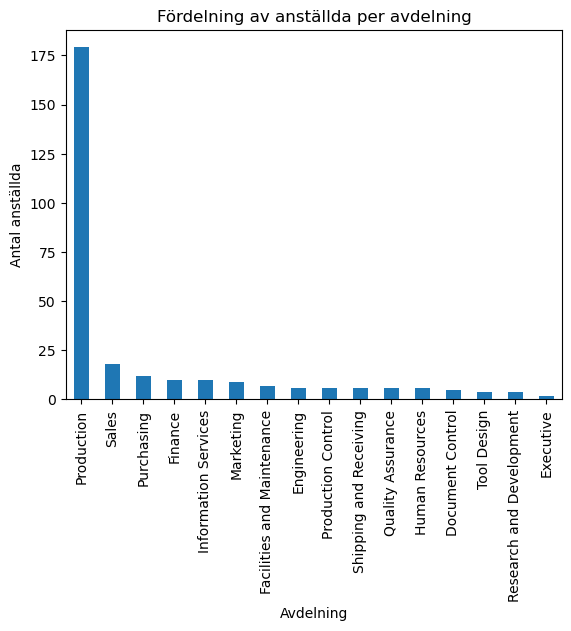

In [96]:
# Hämta datan
df = pd.read_sql(query_1, con=connection)

# Analysera datan
department_distribution = df['Department'].value_counts()
print(department_distribution)

# Visualisera datan
department_distribution.plot(kind='bar')
plt.title('Fördelning av anställda per avdelning')
plt.xlabel('Avdelning')
plt.ylabel('Antal anställda')
plt.show()

In [97]:
# löneanalys för olika avdelningar i företaget
query_2 = """
SELECT 
  d.Name AS Department, 
  eph.Rate
FROM 
  HumanResources.EmployeePayHistory AS eph
INNER JOIN 
  HumanResources.EmployeeDepartmentHistory AS edh 
  ON eph.BusinessEntityID = edh.BusinessEntityID
INNER JOIN 
  HumanResources.Department AS d 
  ON edh.DepartmentID = d.DepartmentID
WHERE 
  edh.EndDate IS NULL  -- Endast aktuella positioner
ORDER BY 
  d.Name;
"""

Department
Executive                     68.303475
Research and Development      43.673100
Engineering                   40.144217
Information Services          34.158630
Sales                         29.971944
Finance                       23.935090
Tool Design                   23.505400
Marketing                     18.431818
Human Resources               18.024817
Purchasing                    18.020200
Production Control            16.774612
Quality Assurance             15.464733
Document Control              14.388460
Production                    13.553767
Facilities and Maintenance    13.031600
Shipping and Receiving        10.871800
Name: Rate, dtype: float64


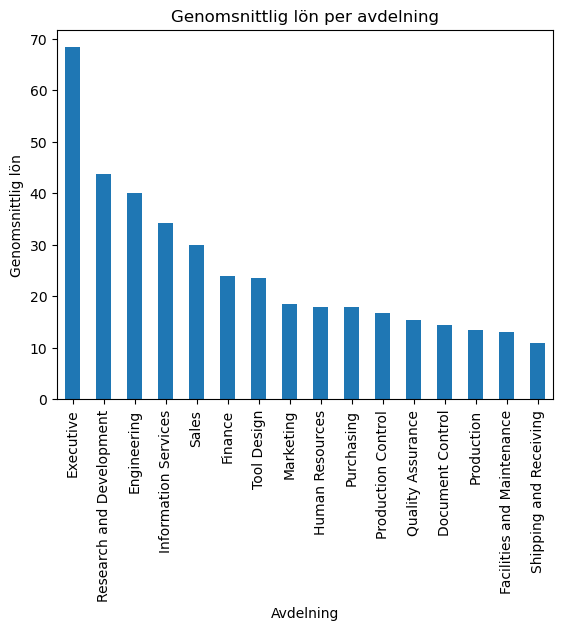

In [138]:
# Hämta datan
df_pay = pd.read_sql(query_2, con=connection)

# Beräkna genomsnittlig lön per avdelning
avg_salary_by_dept = df_pay.groupby('Department')['Rate'].mean()

# Sortera genomsnittliga löner från högst till lägst
avg_salary_by_dept_sorted = avg_salary_by_dept.sort_values(ascending=False)

# Skriv ut de sorterade genomsnittliga lönerna
print(avg_salary_by_dept_sorted)

# Visualisera de sorterade genomsnittliga lönerna
avg_salary_by_dept_sorted.plot(kind='bar')
plt.title('Genomsnittlig lön per avdelning')
plt.xlabel('Avdelning')
plt.ylabel('Genomsnittlig lön')
plt.show()

In [127]:
print(df_sales.columns)

Index(['SalesOrderID', 'OrderDate', 'TotalDue', 'ProductID', 'OrderQty',
       'LineTotal'],
      dtype='object')


In [99]:
#För totalförsäljning
query_total_sales = """
SELECT 
  OrderDate, 
  SUM(TotalDue) AS DailySales
FROM 
  Sales.SalesOrderHeader
GROUP BY 
  OrderDate
ORDER BY 
  OrderDate;
"""

In [100]:
# Hämta datan
df_total_sales = pd.read_sql(query_total_sales, con=connection)


# Beräkna total försäljning
total_sales = df_total_sales['DailySales'].sum()

# Visa den totala försäljningssumman
print(f"Total försäljning: {total_sales}")

Total försäljning: 123216786.11590001


   OnlineOrderFlag    TotalSales
0            False  8.048770e+07
1             True  2.935868e+07


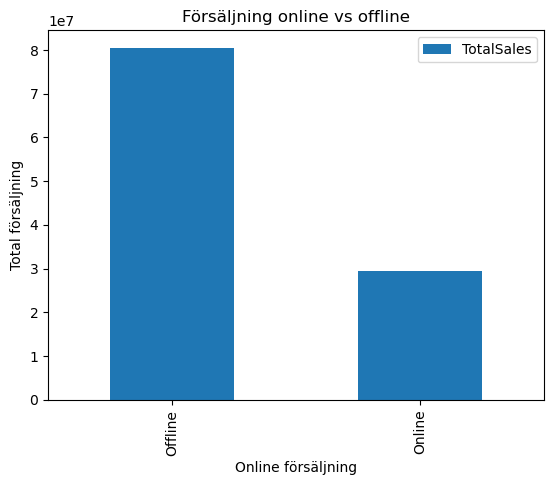

In [209]:
# Analys om produkter säljer bättre online eller offline
query_6 = """
SELECT 
  soh.OnlineOrderFlag, 
  SUM(sod.LineTotal) AS TotalSales
FROM 
  Sales.SalesOrderHeader AS soh
JOIN 
  Sales.SalesOrderDetail AS sod 
  ON soh.SalesOrderID = sod.SalesOrderID
GROUP BY 
  soh.OnlineOrderFlag;
"""

# Hämta datan
df_sales_channel = pd.read_sql(query_6, con=connection)

# Visa resultatet
print(df_sales_channel)

# Visualisera försäljningen Online vs Offline
df_sales_channel.plot(kind='bar', x='OnlineOrderFlag', y='TotalSales')
plt.title('Försäljning online vs offline')
plt.xlabel('Online försäljning')
plt.ylabel('Total försäljning')
plt.xticks([0, 1], ['Offline', 'Online'])
plt.show()

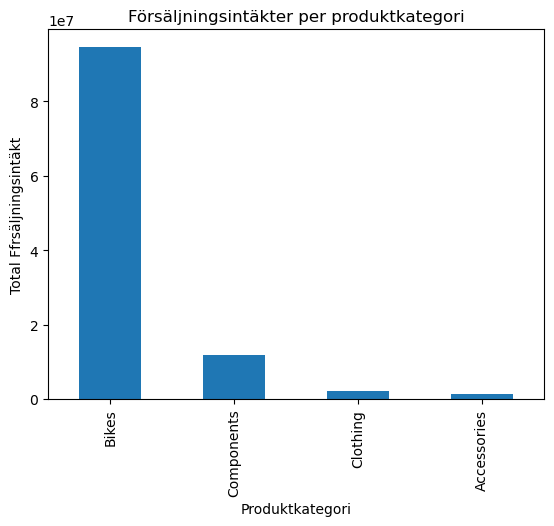

In [210]:
# Analys av försäljning per produkt kategori
df_product_category = pd.read_sql(query_product_category, con=connection)

# Gruppera och summera försäljningsintäkter per produktkategori
df_category_sales = df_product_category.groupby('CategoryName').sum()

# Sortera resultaten i fallande ordning av försäljningsintäkter
df_category_sales_sorted = df_category_sales.sort_values('LineTotal', ascending=False)

# Visualisera resultaten
df_category_sales_sorted['LineTotal'].plot(kind='bar')
plt.xlabel('Produktkategori')
plt.ylabel('Total Ffrsäljningsintäkt')
plt.title('Försäljningsintäkter per produktkategori')
plt.show()

   ProductID                      ProductName  TotalQuantitySold  \
0        712                     AWC Logo Cap               8311   
1        870            Water Bottle - 30 oz.               6815   
2        711           Sport-100 Helmet, Blue               6743   
3        715       Long-Sleeve Logo Jersey, L               6592   
4        708          Sport-100 Helmet, Black               6532   
5        707            Sport-100 Helmet, Red               6266   
6        864                  Classic Vest, S               4247   
7        873              Patch Kit/8 Patches               3865   
8        884  Short-Sleeve Classic Jersey, XL               3864   
9        714       Long-Sleeve Logo Jersey, M               3636   

    TotalRevenue  
0   51229.445623  
1   28654.163327  
2  165406.617049  
3  198754.975360  
4  160869.517836  
5  157772.394392  
6  156398.067950  
7    8232.597632  
8  129145.570124  
9  115249.214976  


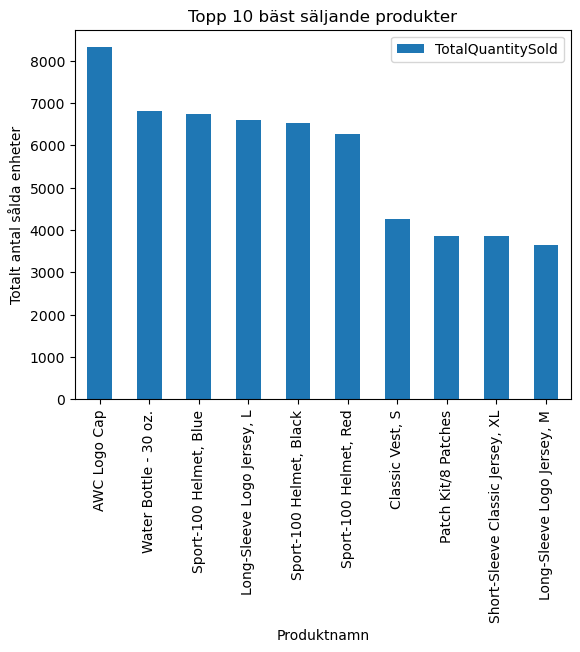

In [204]:
# Analys av de bäst säljande produkterna
query_4 = """
SELECT 
  sod.ProductID, 
  p.Name AS ProductName,
  SUM(sod.OrderQty) AS TotalQuantitySold,
  SUM(sod.LineTotal) AS TotalRevenue
FROM 
  Sales.SalesOrderDetail AS sod
JOIN 
  Production.Product AS p ON sod.ProductID = p.ProductID
GROUP BY 
  sod.ProductID, p.Name
ORDER BY 
  TotalQuantitySold DESC;
"""

# Hämta datan
df_best_selling = pd.read_sql(query_4, con=connection)

# Visa topp 10 bäst säljande produkterna
top_10_best_selling = df_best_selling.head(10)
print(top_10_best_selling)

# Visualisera topp 10 bäst säljande produkterna
top_10_best_selling.plot(kind='bar', x='ProductName', y='TotalQuantitySold')
plt.title('Topp 10 bäst säljande produkter')
plt.xlabel('Produktnamn')
plt.ylabel('Totalt antal sålda enheter')
plt.show()

In [205]:
# Analys av vilka produkter som genererar mest intäkter
query_5 ="""
SELECT 
  sod.ProductID, 
  p.Name AS ProductName,
  SUM(sod.LineTotal) AS TotalRevenue,
  SUM(sod.OrderQty) AS TotalQuantitySold
FROM 
  Sales.SalesOrderDetail AS sod
JOIN 
  Production.Product AS p ON sod.ProductID = p.ProductID
GROUP BY 
  sod.ProductID, p.Name
ORDER BY 
  TotalRevenue DESC;
"""

   ProductID              ProductName  TotalRevenue  TotalQuantitySold
0        782   Mountain-200 Black, 38  4.400593e+06               2977
1        783   Mountain-200 Black, 42  4.009495e+06               2664
2        779  Mountain-200 Silver, 38  3.693678e+06               2394
3        780  Mountain-200 Silver, 42  3.438479e+06               2234
4        781  Mountain-200 Silver, 46  3.434257e+06               2216
5        784   Mountain-200 Black, 46  3.309673e+06               2111
6        793       Road-250 Black, 44  2.516857e+06               1642
7        794       Road-250 Black, 48  2.347656e+06               1498
8        795       Road-250 Black, 52  2.012448e+06               1245
9        753         Road-150 Red, 56  1.847819e+06                664


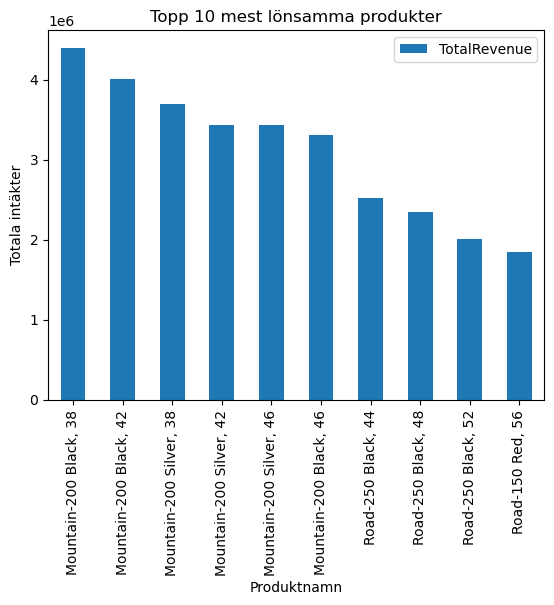

In [207]:
# Hämta datan
df_profitable = pd.read_sql(query_5, con=connection)

# Visa topp 10 mest lönsamma produkterna baserat på intäkter
top_10_profitable_and_sold = df_profitable_and_sold.head(10)
print(top_10_profitable_and_sold)

# Visualisera topp 10 mest lönsamma produkterna
top_10_profitable.plot(kind='bar', x='ProductName', y='TotalRevenue')
plt.title('Topp 10 mest lönsamma produkter')
plt.xlabel('Produktnamn')
plt.ylabel('Totala intäkter')
plt.show()

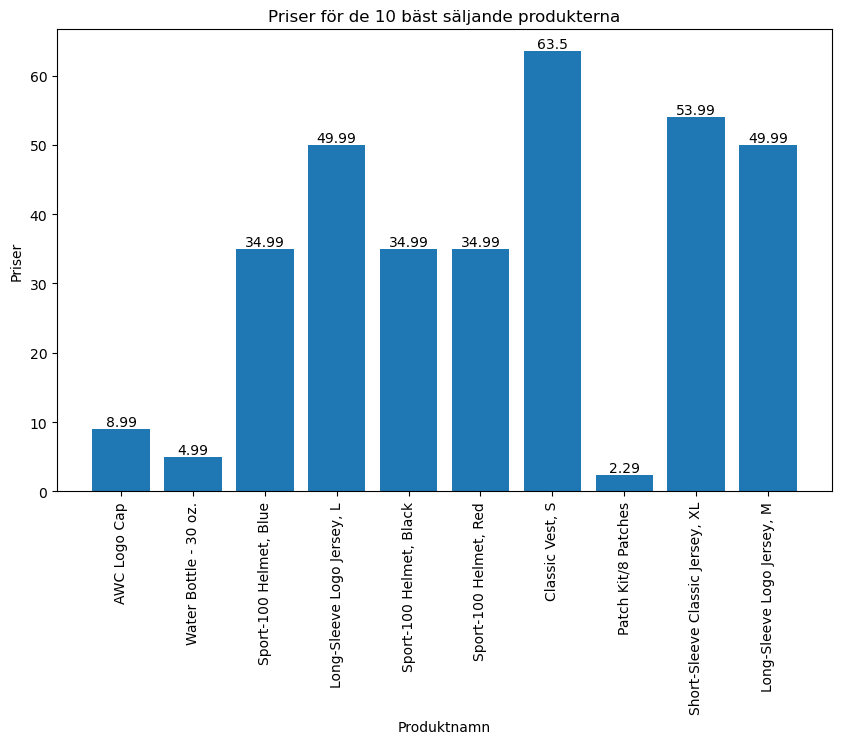

In [189]:
# Analays för att visa priser över de 10 bäst sålda produkterna
query_best_selling_products = """
SELECT TOP 10 ProductID, SUM(OrderQty) AS TotalSold
FROM Sales.SalesOrderDetail
GROUP BY ProductID
ORDER BY SUM(OrderQty) DESC;
"""

query_product_prices = """
SELECT ProductID, Name, ListPrice
FROM Production.Product;
"""

# Använd Pandas för att köra SQL-frågorna och hämta data
df_best_selling = pd.read_sql(query_best_selling_products, con=connection)
df_prices = pd.read_sql(query_product_prices, con=connection)

# Kombinera datan för att matcha produkt-ID och priser
combined_data = pd.merge(df_best_selling, df_prices, on="ProductID")

# Sortera baserat på antal sålda enheter
combined_data_sorted = combined_data.sort_values(by='TotalSold', ascending=False)

# Skapa en plot
plt.figure(figsize=(10, 6))
bars = plt.bar(combined_data_sorted["Name"], combined_data_sorted["ListPrice"])

# Lägg till prisvärden på varje stolpe
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom', ha='center')  # Justera positionen efter behov

plt.xlabel('Produktnamn')
plt.ylabel('Priser')
plt.title('Priser för de 10 bäst säljande produkterna')
plt.xticks(rotation=90)
plt.show()

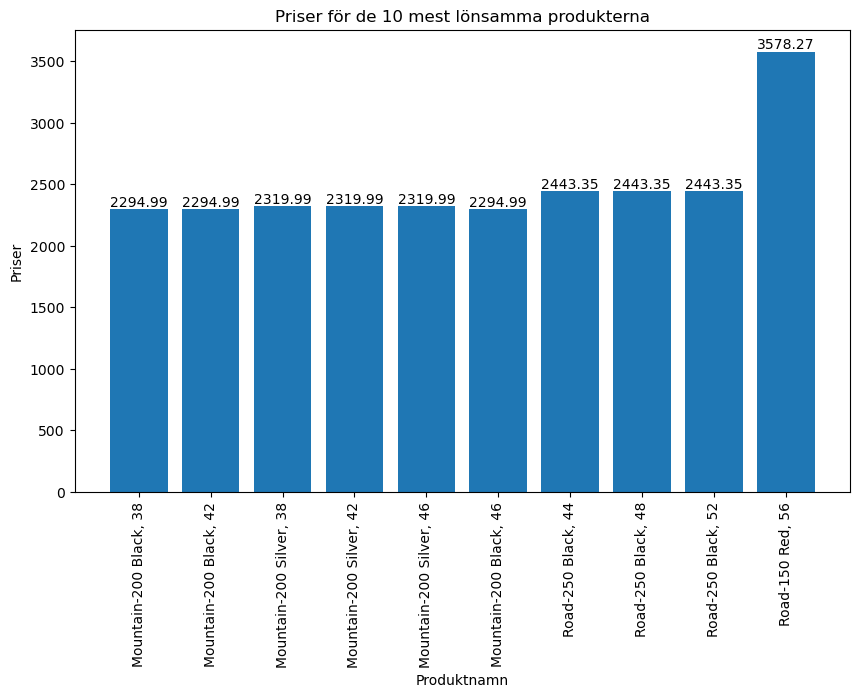

In [208]:
# Analys för att hämta de mest lönsamma produkterna
query_most_profitable_products = """
SELECT TOP 10 sod.ProductID, SUM(sod.LineTotal) AS TotalRevenue
FROM Sales.SalesOrderDetail AS sod
GROUP BY sod.ProductID
ORDER BY SUM(sod.LineTotal) DESC;
"""

# SQL-fråga för att hämta prisinformation
query_product_prices = """
SELECT ProductID, Name, ListPrice
FROM Production.Product;
"""

# Hämta data
df_most_profitable = pd.read_sql(query_most_profitable_products, con=connection)
df_prices = pd.read_sql(query_product_prices, con=connection)

# Kombinera datan för att matcha produkt-ID och priser
combined_data_profitable = pd.merge(df_most_profitable, df_prices, on="ProductID")

# Sortera baserat på totala intäkter
combined_data_sorted_profitable = combined_data_profitable.sort_values(by='TotalRevenue', ascending=False)

# Skapa en plot
plt.figure(figsize=(10, 6))
bars_profitable = plt.bar(combined_data_sorted_profitable["Name"], combined_data_sorted_profitable["ListPrice"])

# Lägg till prisvärden på varje stolpe
for bar in bars_profitable:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom', ha='center')  # Justera positionen efter behov

plt.xlabel('Produktnamn')
plt.ylabel('Priser')
plt.title('Priser för de 10 mest lönsamma produkterna')
plt.xticks(rotation=90)
plt.show()

OrderDate
2011-05    8.094970e+06
2011-06    5.070965e+05
2011-07    2.608142e+07
2011-08    3.800996e+07
2011-09    5.547916e+05
2011-10    8.573987e+07
2011-11    8.153130e+05
2011-12    1.098031e+07
2012-01    5.743832e+07
2012-02    1.792551e+07
2012-03    4.927356e+07
2012-04    2.606104e+07
2012-05    1.192323e+08
2012-06    1.687460e+08
2012-07    1.414237e+08
2012-08    7.558641e+07
2012-09    1.223055e+08
2012-10    8.901987e+07
2012-11    3.977622e+07
2012-12    6.598887e+07
2013-01    4.571396e+07
2013-02    8.138381e+07
2013-03    1.182912e+08
2013-04    8.188507e+07
2013-05    1.282748e+08
2013-06    1.962551e+08
2013-07    1.925832e+08
2013-08    9.361898e+07
2013-09    1.340201e+08
2013-10    1.370603e+08
2013-11    5.434172e+07
2013-12    7.954001e+07
2014-01    8.022601e+07
2014-02    4.094288e+06
2014-03    2.150542e+08
2014-04    5.567935e+06
2014-05    1.353521e+08
2014-06    1.461499e+05
Freq: M, Name: TotalDue, dtype: float64


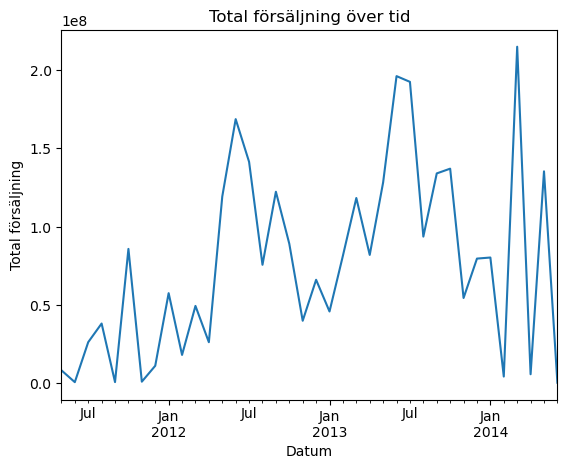

In [211]:
# Grundläggande försäljningsanalys för att hämta försäljningsdata
query_3 = """
SELECT 
  soh.SalesOrderID, 
  soh.OrderDate, 
  soh.TotalDue, 
  sod.ProductID, 
  sod.OrderQty, 
  sod.LineTotal
FROM 
  Sales.SalesOrderHeader AS soh
INNER JOIN 
  Sales.SalesOrderDetail AS sod 
  ON soh.SalesOrderID = sod.SalesOrderID;
"""

# Hämta datan
df_sales = pd.read_sql(query_3, con=connection)

# Konvertera 'OrderDate' till datetime format för tidsbaserad analys
df_sales['OrderDate'] = pd.to_datetime(df_sales['OrderDate'])

# Gruppera datan per månad och summera 'TotalDue'
total_sales_over_time = df_sales.groupby(df_sales['OrderDate'].dt.to_period('M'))['TotalDue'].sum()

# Skriv ut total försäljning över tid
print(total_sales_over_time)

# Visualisera total försäljning över tid
total_sales_over_time.plot(kind='line')
plt.title('Total försäljning över tid')
plt.xlabel('Datum')
plt.ylabel('Total försäljning')
plt.show()

In [121]:
# Analys för att hämta försäljningsorderdetaljer
query_sales_detail = """
SELECT soh.OrderDate, sod.ProductID, sod.LineTotal
FROM Sales.SalesOrderHeader AS soh
JOIN Sales.SalesOrderDetail AS sod ON soh.SalesOrderID = sod.SalesOrderID;
"""

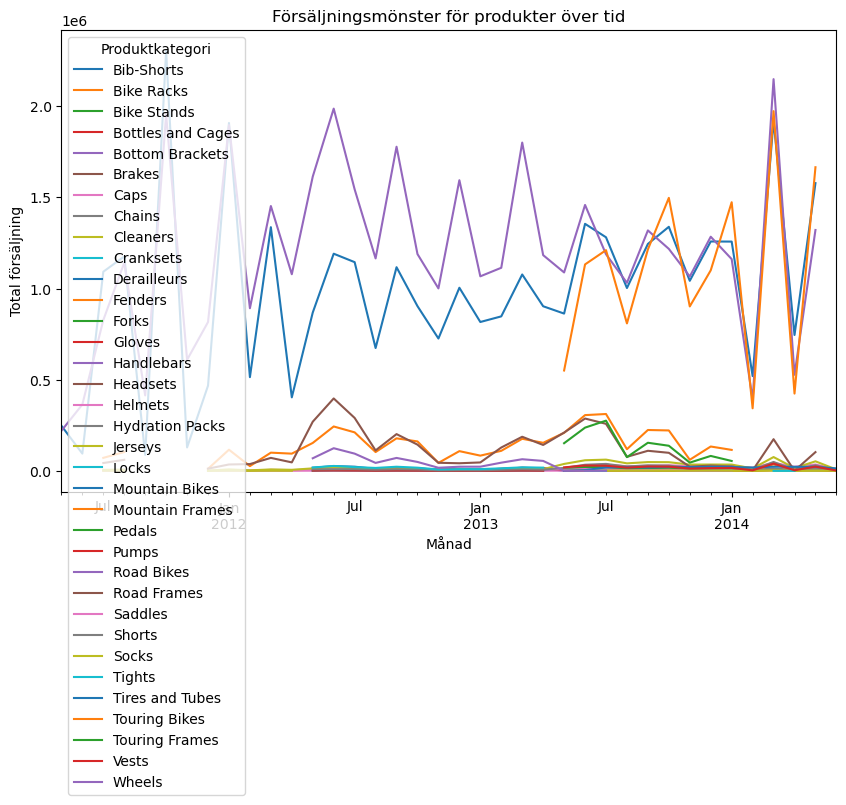

In [212]:
df_sales_detail = pd.read_sql(query_sales_detail, con=connection)

# Sammanfoga försäljningsdetaljer med produktinformation
df_merged = pd.merge(df_sales_detail, df_product, on='ProductID', how='left')

# Sammanfoga med kategoriinformation
df_merged = pd.merge(df_merged, df_subcategory, on='ProductSubcategoryID', how='left')

# Konvertera 'OrderDate' till datetime och gruppera per månad och kategori
df_merged['OrderDate'] = pd.to_datetime(df_merged['OrderDate'])
df_grouped = df_merged.groupby([pd.Grouper(key='OrderDate', freq='M'), 'SubcategoryName']).sum()['LineTotal']

# Visualisera datan
df_grouped.unstack().plot(kind='line', figsize=(10, 6))
plt.title('Försäljningsmönster för produkter över tid')
plt.xlabel('Månad')
plt.ylabel('Total försäljning')
plt.legend(title='Produktkategori')
plt.show()

In [157]:
# Försäljning över topp bästa sålda produkter
query_sales_with_product_name = """
SELECT 
  soh.SalesOrderID, 
  soh.OrderDate, 
  soh.TotalDue, 
  sod.ProductID, 
  sod.OrderQty, 
  sod.LineTotal,
  p.Name AS ProductName
FROM 
  Sales.SalesOrderHeader AS soh
INNER JOIN 
  Sales.SalesOrderDetail AS sod ON soh.SalesOrderID = sod.SalesOrderID
INNER JOIN 
  Production.Product AS p ON sod.ProductID = p.ProductID;
"""

df_sales_with_product_name = pd.read_sql(query_sales_with_product_name, con=connection)

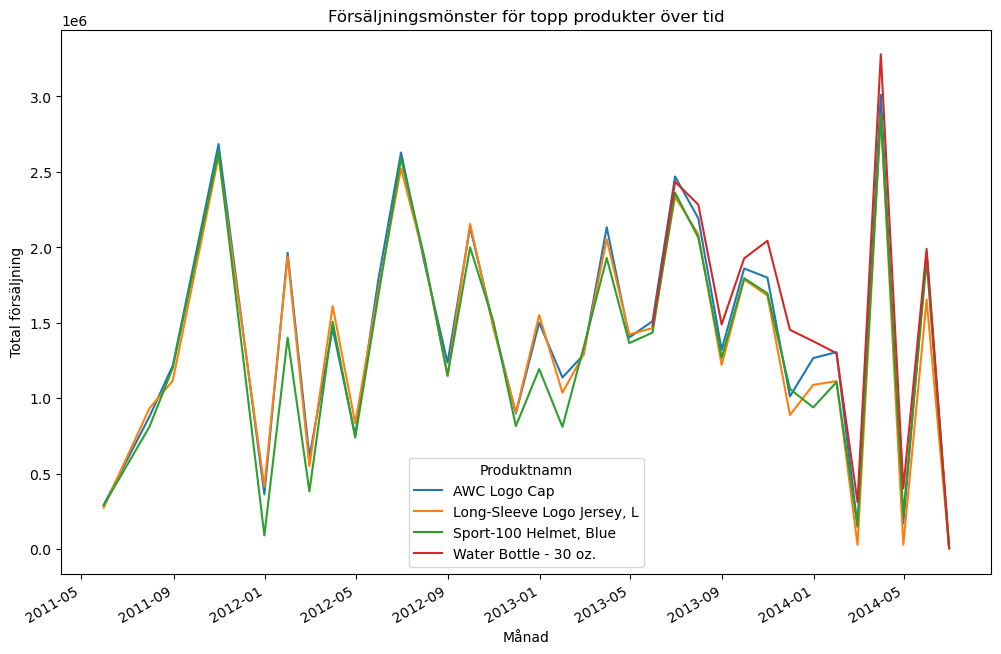

In [166]:
df_sales_summarized = df_sales_with_product_name[['ProductName', 'OrderQty', 'TotalDue']]

# Identifiera de mest sålda produkterna baserat på antal sålda enheter
top_10_product_names = df_sales_summarized.groupby('ProductName').sum().sort_values('OrderQty', ascending=False).head(4).index

# Filtrera datan för att inkludera endast de tio mest sålda produkterna
df_top_products = df_sales_with_product_name[df_sales_with_product_name['ProductName'].isin(top_10_product_names)]

# Filtrera datan för att inkludera endast de tio mest sålda produkterna
df_grouped_top = df_top_products.groupby([pd.Grouper(key='OrderDate', freq='M'), 'ProductName']).sum()['TotalDue']

# Visualisera datan
df_grouped_top.unstack().plot(kind='line', figsize=(12, 8))
plt.title('Försäljningsmönster för topp produkter över tid')
plt.xlabel('Månad')
plt.ylabel('Total försäljning')
plt.legend(title='Produktnamn')
plt.show()

In [159]:
# Försäljning över mest lönsamma sålda produkter
query_sales_with_product_name = """
SELECT 
  soh.SalesOrderID, 
  soh.OrderDate, 
  soh.TotalDue, 
  sod.ProductID, 
  sod.OrderQty, 
  sod.LineTotal,
  p.Name AS ProductName
FROM 
  Sales.SalesOrderHeader AS soh
INNER JOIN 
  Sales.SalesOrderDetail AS sod ON soh.SalesOrderID = sod.SalesOrderID
INNER JOIN 
  Production.Product AS p ON sod.ProductID = p.ProductID;
"""

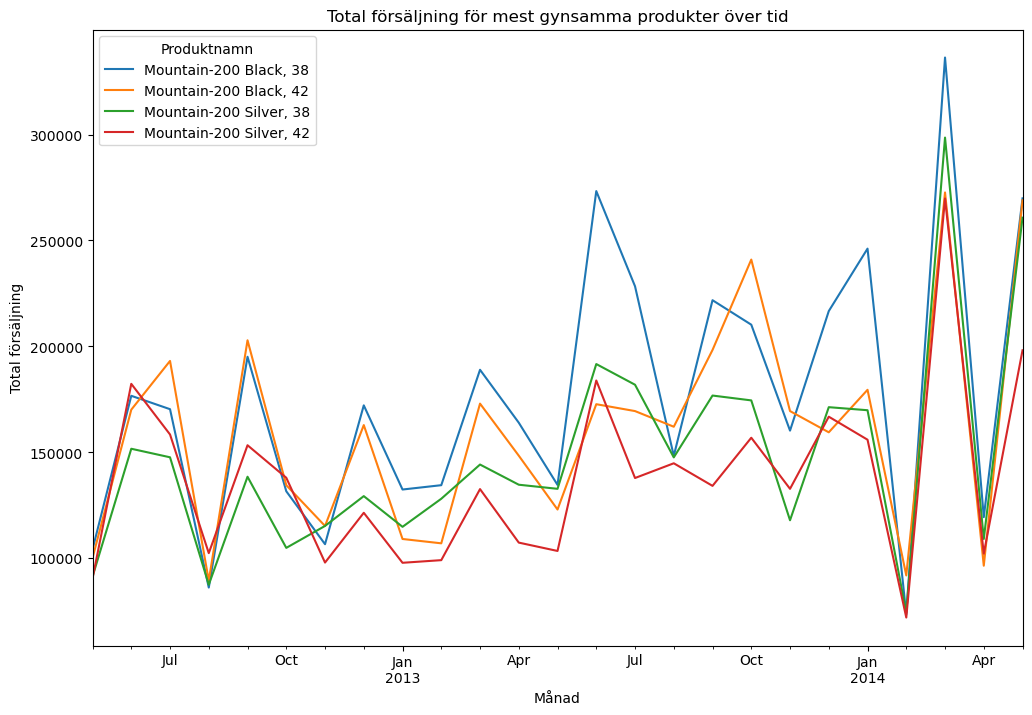

In [215]:
# Läs in data från SQL-frågan
df_sales_with_product_name = pd.read_sql(query_sales_with_product_name, con=connection)

# Summera 'OrderQty' och 'LineTotal' för varje 'ProductName'
grouped = df_sales_with_product_name.groupby('ProductName').agg({'OrderQty': 'sum', 'LineTotal': 'sum'})

# Sortera efter 'LineTotal' för att hitta de produkter med högst totalförsäljning
top_products_by_revenue = grouped.sort_values('LineTotal', ascending=False).head(4).index

# Filtrera datan för att inkludera endast topprodukterna
df_top_products_by_revenue = df_sales_with_product_name[df_sales_with_product_name['ProductName'].isin(top_products_by_revenue)]

# Gruppera och summera 'LineTotal' per månad och produkt
df_grouped_top_revenue = df_top_products_by_revenue.groupby([pd.Grouper(key='OrderDate', freq='M'), 'ProductName'])['LineTotal'].sum()

# Visualisera datan
df_grouped_top_revenue.unstack().plot(kind='line', figsize=(12, 8))
plt.title('Total försäljning för mest gynsamma produkter över tid')
plt.xlabel('Månad')
plt.ylabel('Total försäljning')
plt.legend(title='Produktnamn')
plt.show()

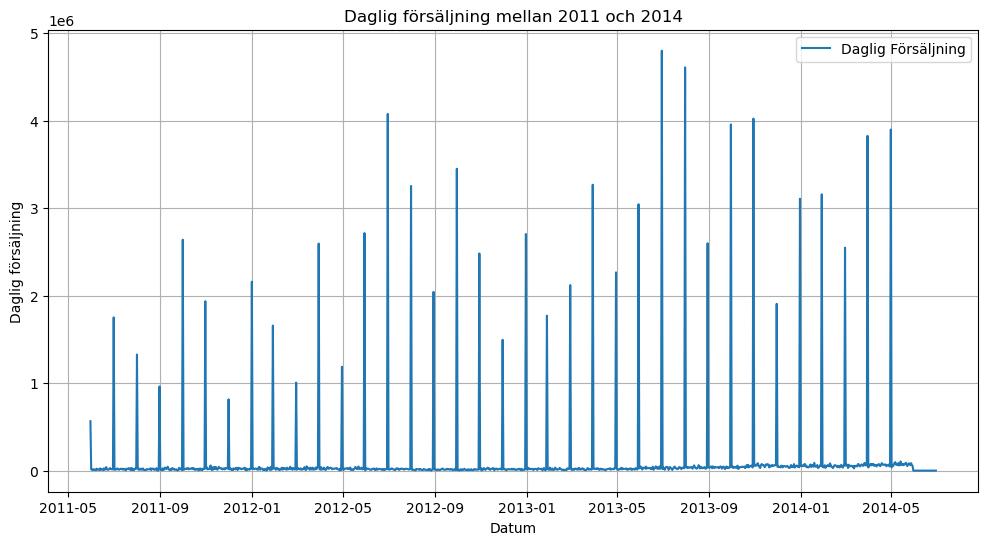

In [216]:
# Analys för daglig försäljning 
query_daily_sales = """
SELECT 
  CAST(OrderDate AS DATE) AS SalesDate, 
  SUM(TotalDue) AS DailySales
FROM 
  Sales.SalesOrderHeader
WHERE 
  YEAR(OrderDate) BETWEEN 2011 AND 2014
GROUP BY 
  CAST(OrderDate AS DATE)
ORDER BY 
  SalesDate;
"""
df_daily_sales = pd.read_sql(query_daily_sales, con=connection)

# Konvertera 'SalesDate' till datetime
df_daily_sales['SalesDate'] = pd.to_datetime(df_daily_sales['SalesDate'])

# Visualisera den dagliga försäljningen
plt.figure(figsize=(12, 6))
plt.plot(df_daily_sales['SalesDate'], df_daily_sales['DailySales'], label='Daglig Försäljning')
plt.xlabel('Datum')
plt.ylabel('Daglig försäljning')
plt.title('Daglig försäljning mellan 2011 och 2014')
plt.legend()
plt.grid(True)
plt.show()

In [115]:
# Antag att df_total_sales är din DataFrame med dagliga försäljningsdata
daily_sales = df_total_sales['DailySales']

# Beräkna konfidensintervallet för genomsnittlig daglig försäljning
ci = stats.norm.interval(0.95, loc=np.mean(daily_sales), scale=stats.sem(daily_sales))

print(f"Konfidensintervall för genomsnittlig daglig försäljning: {ci}")

Konfidensintervall för genomsnittlig daglig försäljning: (81299.22138786633, 137947.72899629737)
